<a href="https://colab.research.google.com/github/Rishabh2027/CustomerChurn/blob/main/customer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv("/content/drive/MyDrive/Dataset/customerchurn.csv")

# Convert 'Churn' to numeric
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

# Handle missing values in 'TotalCharges'
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# Apply Label Encoding to categorical columns
label_enc = LabelEncoder()
categorical_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                    'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
                    'PaperlessBilling', 'PaymentMethod']

for col in categorical_cols:
    df[col] = label_enc.fit_transform(df[col])

# Select features and target
X = df.drop(columns=['Churn', 'customerID'])
y = df['Churn']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


<ipython-input-2-9359269789b3>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


In [3]:
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb,
                               scoring='accuracy', cv=3, n_jobs=-1, verbose=1)

grid_search_xgb.fit(X_train, y_train)

# Train best XGBoost model
best_xgb_model = xgb.XGBClassifier(**grid_search_xgb.best_params_, use_label_encoder=False, eval_metric='logloss')
best_xgb_model.fit(X_train, y_train)

# Predict on test set
y_pred_xgb = best_xgb_model.predict(X_test)


Fitting 3 folds for each of 32 candidates, totalling 96 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:20:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:21:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [4]:
# Standardize features for SVM (required for better performance)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define SVM parameter grid
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

svm_model = SVC()

grid_search_svm = GridSearchCV(svm_model, param_grid_svm, scoring='accuracy', cv=3, n_jobs=-1, verbose=1)
grid_search_svm.fit(X_train_scaled, y_train)

# Train best SVM model
best_svm_model = SVC(**grid_search_svm.best_params_)
best_svm_model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred_svm = best_svm_model.predict(X_test_scaled)


Fitting 3 folds for each of 12 candidates, totalling 36 fits


XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.91      0.88      1036
           1       0.68      0.55      0.61       373

    accuracy                           0.81      1409
   macro avg       0.76      0.73      0.74      1409
weighted avg       0.80      0.81      0.81      1409

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.92      0.87      1036
           1       0.68      0.50      0.58       373

    accuracy                           0.81      1409
   macro avg       0.76      0.71      0.73      1409
weighted avg       0.80      0.81      0.80      1409



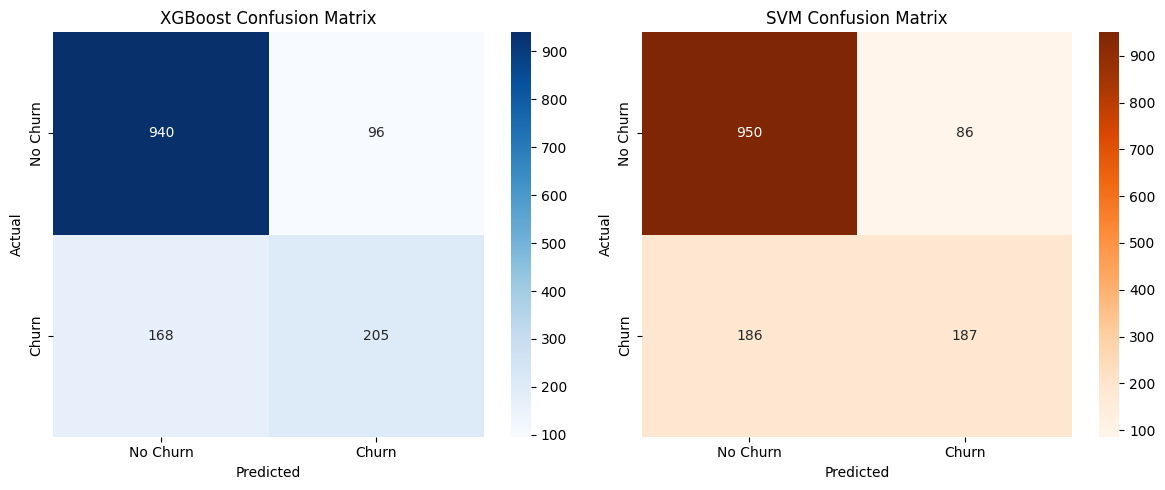

In [5]:
# Compute confusion matrices
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
cm_svm = confusion_matrix(y_test, y_pred_svm)

# Print classification reports
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))

# Plot confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'], ax=ax[0])
ax[0].set_title("XGBoost Confusion Matrix")
ax[0].set_xlabel("Predicted")
ax[0].set_ylabel("Actual")

sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Oranges', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'], ax=ax[1])
ax[1].set_title("SVM Confusion Matrix")
ax[1].set_xlabel("Predicted")
ax[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()
